[[5.71921866 3.08239417 7.34459222 7.05149808]]
[[8.80750028 4.80650769]]
[[10.7329241   5.10910857]]
[4.9477652  8.26386246 5.81065219 ... 4.29515369 6.00488938 8.53846846]
Init mean
[15.37613188 13.37145664 16.93461322 10.23616811]
Init s2
[0.34500213 0.31143211 0.55804008 0.8733443 ]
5 [4.33864309 8.96398615 1.58801745 6.55106103]
ELBO ended with ll -631.665
[-157272.9265667072, -13456.616537169706, -1384.7219798731403, -784.0746408910229, -674.9472029829344, -631.6654346510658]
[[14.24111547  5.47063633]]
cpu usage		:  %
memory usage		: 0.15 %
time : 0.026928186416625977


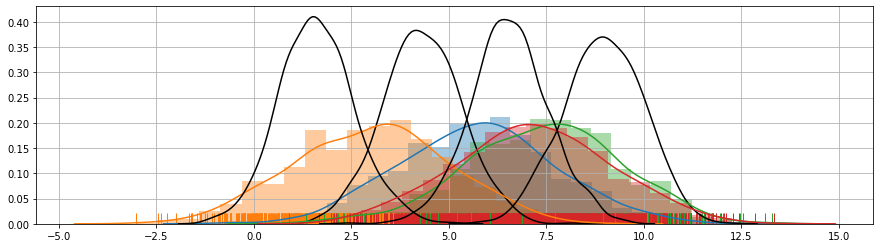

In [47]:
import numpy as np
import seaborn as sns

def h(x,H):
    d = x-H
    d = np.multiply(d,d)
    d = np.sqrt(d.sum(axis=1))
    d_col_1 = d[1]-d[0]
    d_col_2 = d[2]-d[0] 
    d_col_3 = d[3]-d[0]
    di = np.array([d_col_1,d_col_2,d_col_3])
    di = di.T
    return di

class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=4, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)
        self.s2 = np.ones(self.K) * np.random.random(self.K)
        print('Init mean')
        print(self.m)
        print('Init s2')
        print(self.s2)

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=5, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))
            print(self.elbo_values)

    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K

import os
import psutil

def _check_usage_of_cpu_and_memory():
    
    pid = os.getpid()
    py  = psutil.Process(pid)
    
    cpu_usage   = os.popen("ps aux | grep " + str(pid) + " | grep -v grep | awk '{print $3}'").read()
    cpu_usage   = cpu_usage.replace("\n","")
    
    memory_usage  = round(py.memory_info()[0] /2.**30, 2)
    
    print("cpu usage\t\t:", cpu_usage, "%")
    print("memory usage\t\t:", memory_usage, "%")
        
        
def tri(zd, H):
    zd = zd.T
    H=H-H[0]
    tmp = zd[0]
    tmp = tmp * tmp
    zd = np.delete(zd,(0), axis=0)
    r1=np.multiply(zd,zd)
    Ha=np.delete(H,(0), axis=0)
    K=np.multiply(Ha,Ha)
    K=K.sum(axis=1)
    b= 0.5*(K-r1+tmp) 
    S_inv = np.linalg.inv(Ha.T*Ha)*Ha.T
    x_hat = S_inv*b
    return x_hat

import matplotlib.pyplot as plt
import seaborn as sns

from openpyxl import Workbook
write_wb = Workbook()
 
#이름이 있는 시트를 생성
#write_ws = write_wb.create_sheet('생성시트') 
#Sheet1에다 입력

bias = 0
std = 2

x = np.array([7.54,4.8])
H = np.array([[7.54,0],[7.54,7.21],[14.14,0],[14.14,7.58]])
H2 = np.matrix([[7.54,0],[7.54,7.21],[14.14,0],[14.14,7.58]])
d = x-H
d = np.multiply(d,d)
d = np.sqrt(d.sum(axis=1))

d[0] = d[0] + np.random.normal(bias,1,1)
d[1] = d[1] + np.random.normal(bias,1,1)
d[2] = d[2] + np.random.normal(bias,1,1)
d[3] = d[3] + np.random.normal(bias,1,1)
zd = np.matrix([d[0],d[1],d[2],d[3]])
zd2 = np.matrix([[6.82034457, 2.93400688, 5.70111908, 6.58487352]])
print(zd)
x_hat = tri(zd,H2)
x_hat = x_hat.T+H[0]
print(x_hat)
x_hat = tri(zd2,H2)
x_hat = x_hat.T+H[0]
print(x_hat)
#X1 = d[0] + gibbs_sampling(0,std,SAMPLE)

SAMPLE = 1000
X1 = d[0] + np.random.normal(0,std,SAMPLE)#np.random.normal(loc=d[0], scale=std, size=SAMPLE)
X2 = d[1] + np.random.normal(0,std,SAMPLE)#np.random.normal(loc=d[1], scale=std, size=SAMPLE)
X3 = d[2] + np.random.normal(0,std,SAMPLE)#np.random.normal(loc=d[2], scale=std, size=SAMPLE)
X4 = d[3] + np.random.normal(0,std,SAMPLE)#np.random.normal(loc=d[3], scale=std, size=SAMPLE)
X1 = X1.T
X2 = X2.T
X3 = X3.T
X4 = X4.T
X = np.append(X1,X2)
X = np.append(X,X3)
X = np.append(X,X4)
print(X)

#for i, mu in enumerate(mu_arr[1:]):
#    X = np.append(X, np.random.normal(loc=mu, scale=1, size=SAMPLE))
import time
start = time.time()
ugmm = UGMM(X, 4)
ugmm.fit()
ugmm.phi.argmax(1)
zd = np.matrix([ugmm.m[0],ugmm.m[1],ugmm.m[2],ugmm.m[3]])
x_hat = tri(zd,H2)
x_hat = x_hat.T+H[0]
print(x_hat)
_check_usage_of_cpu_and_memory()
print("time :", time.time() - start)
#write_ws = write_wb.active
#write_ws['A1'] = 'REAL'
#write_ws['C1'] = 'VI'
#행 단위로 추가
#write_ws.append([1,2,3])
#셀 단위로 추가
#write_ws.cell(i,1,x_hat(0,0))
#write_ws.cell(i,2,x_hat(0,1))
#write_wb.save('/Users/swbaek/Desktop/VI.xlsx')
#sorted(mu_arr)
#sorted(ugmm.m)
#for i in range(0,3)
x_init = np.array([1,1])

fig, ax = plt.subplots(figsize=(15, 4))
plt.grid()
sns.distplot(X[:SAMPLE], ax=ax, hist=True, rug = True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[0], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE:SAMPLE*2], ax=ax, hist=True,rug = True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[1], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE*2:SAMPLE*3], ax=ax, hist=True,rug = True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[2], 1, SAMPLE), color='k', hist=False, kde=True)
sns.distplot(X[SAMPLE*3:], ax=ax, hist=True, rug = True, norm_hist=True)
sns.distplot(np.random.normal(ugmm.m[3], 1, SAMPLE), color='k', hist=False, kde=True)
#print(ugmm.m_history)


In [4]:
print(X1)

[8.74579245 6.36594341 3.59470196 5.65992536 2.62982466 7.51432955
 5.47384694 6.99771237 6.45854114 3.91767537]


In [14]:
K = X[0]
K = np.append(K,X[SAMPLE])
K = np.append(K,X[2*SAMPLE])
K = np.append(K,X[3*SAMPLE])
print(K)

[6.89828027 3.32803102 7.0258703  4.69247879]


In [103]:
print(np.random.randint(1, 10))

6


In [99]:
from scipy.stats import boltzmann
N = 100
lambda_ = 1.4
print(boltzmann.rvs(lambda_, N, size=10))

[0 0 1 0 0 1 0 0 0 0]


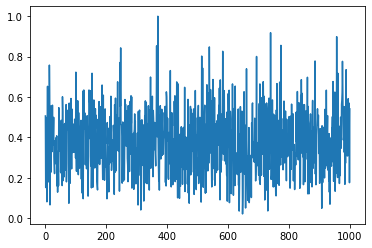

In [191]:
from scipy.stats import maxwell
r = maxwell.rvs(size=1000)
r_max = max(r)
r=(r/r_max)
x = np.linspace(1,1000, num = 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, r)

0.5870394595295735


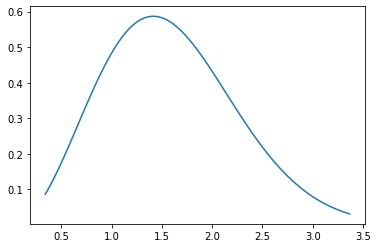

In [46]:
import numpy as np
from scipy.stats import maxwell
x = np.linspace(maxwell.ppf(0.01),
                maxwell.ppf(0.99), 100)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(x, maxwell.pdf(x))
print(maxwell.pdf(1.4098492385705015))